# Bitcoin Trading Bot Optimization

This notebook integrates all components of the trading bot and optimization algorithms (PSO, ABC, HCA).  
To run the complete experiment, execute all cells in order. Ensure the dataset `BTC-Daily.csv` is located in the `/data` folder.

## Contents:
- Data import and pre-processing
- Moving average logic (SMA, LMA, EMA)
- Crossover signal generation
- Evaluation function
- Optimization with:
  - Particle Swarm Optimization (PSO)
  - Artificial Bee Colony (ABC)
  - Hill Climbing Algorithm (HCA)
- Result plots and final comparison


In [ ]:
#Evaluation function, plot function, MA functions
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

DATA_PATH = "data/BTC-Daily.csv"


def import_data(path):
    """
    Import Bitcoin price data
    Returns: 2D numpy array with unix timestamp and closing prices as rows
    """
    df = pd.read_csv(path)
    arr = df[["unix", "close"]].to_numpy().T
    arr = arr[:, arr[0, :].argsort()]
    return arr


def training_testing_split(data, unix_cutoff):
    training = data[:, data[0] < unix_cutoff]
    testing = data[:, data[0] >= unix_cutoff]
    return training, testing


def pad(price, days):
    """ Pad the price array """
    padding = -np.flip(price[1:days])
    return np.append(padding, price)


def WMA(price, days, kernel):
    price = pad(price, days)
    wma = np.correlate(price, kernel, mode="valid")
    return wma


def SMA(price, days):
    """Simple Moving Average"""
    K = 1 / days * np.ones(days)
    return WMA(price, days, K)


def LMA(price, days):
    """Linear Moving Average"""
    K = 2 * np.linspace(0, 1 / days, days)
    return WMA(price, days, K)


def EMA(price, days, alpha):
    """Exponential Moving Average"""
    K = alpha * np.power(1 - alpha, np.linspace(0, days, days)[::-1])
    K_sum = np.sum(K)
    if K_sum > 0:  # Prevent division by zero
        K /= K_sum
    return WMA(price, days, K)


def combined_WMA(price, sma_weight, sma_length, lma_weight, lma_length, ema_weight, ema_length, ema_alpha):
    """Combined Weighted Moving Average"""
    # Ensure all length parameters are integers
    sma_length = int(round(sma_length))
    lma_length = int(round(lma_length))
    ema_length = int(round(ema_length))

    # Calculate individual moving averages
    sma = SMA(price, sma_length)
    lma = LMA(price, lma_length)
    ema = EMA(price, ema_length, ema_alpha)

    # Calculate total weight
    total_weight = sma_weight + lma_weight + ema_weight
    if total_weight > 0:  # Prevent division by zero
        return (sma_weight * sma + lma_weight * lma + ema_weight * ema) / total_weight
    else:
        return (sma + lma + ema) / 3  # Fallback to simple average if all weights are zero


def generate_ma_crossover_signals(short_ma, long_ma):
    """Generate moving average crossover signals"""
    if len(short_ma) != len(long_ma):
        print("Warning: Moving averages have different lengths")
        min_len = min(len(short_ma), len(long_ma))
        short_ma = short_ma[-min_len:]
        long_ma = long_ma[-min_len:]

    crossover_signals = np.zeros(len(short_ma), dtype=int)
    diff = short_ma - long_ma

    for i in range(1, len(short_ma)):
        if diff[i] > 0 and diff[i - 1] <= 0:
            crossover_signals[i] = 1
        elif diff[i] < 0 and diff[i - 1] >= 0:
            crossover_signals[i] = -1

    return crossover_signals


def evaluate(parameters, prices, start_amount=1000, fee_rate=0.03, verbose=False, plot=False):
    """Evaluate trading strategy performance"""
    # Ensure all length parameters are integers
    integer_params = [1, 3, 5, 8, 10, 12]
    for i in integer_params:
        parameters[i] = int(round(parameters[i]))

    # Split parameters into short-term and long-term
    short_params = parameters[:7]
    long_params = parameters[7:]

    # Calculate short-term and long-term moving averages
    short_wma = combined_WMA(prices,
                             short_params[0],  # sma_weight
                             short_params[1],  # sma_length
                             short_params[2],  # lma_weight
                             short_params[3],  # lma_length
                             short_params[4],  # ema_weight
                             short_params[5],  # ema_length
                             short_params[6])  # ema_alpha

    long_wma = combined_WMA(prices,
                            long_params[0],  # sma_weight
                            long_params[1],  # sma_length
                            long_params[2],  # lma_weight
                            long_params[3],  # lma_length
                            long_params[4],  # ema_weight
                            long_params[5],  # ema_length
                            long_params[6])  # ema_alpha

    buy_signal = generate_ma_crossover_signals(short_wma, long_wma)

    cash = start_amount
    btc = 0.0

    for i, signal in enumerate(buy_signal):
        current_price = prices[i]
        if signal == 1 and cash > 0:
            btc = cash / current_price * (1 - fee_rate)
            if verbose: print(f"Buy {btc:.2f}BTC with {cash:.2f}USD at time {i}")
            cash = 0.0
        elif signal == -1 and btc > 0:
            cash = btc * current_price * (1 - fee_rate)
            if verbose: print(f"Sell {btc:.2f}BTC for {cash:.2f}USD at time {i}")
            btc = 0.0

    if btc > 0:
        cash = btc * prices[-1] * (1 - fee_rate)

    if plot: plot_ma_signals(prices, short_wma, long_wma, buy_signal)

    return cash


def plot_ma_signals(prices, short_wma, long_wma, buy_signal, save_fig=False, fig_path=None):
    """Plot moving average signals"""
    plt.figure(figsize=(12, 8))

    plt.plot(prices, label='Price', alpha=0.5, linewidth=1)
    plt.plot(short_wma, label=f'Short WMA', linewidth=1.5)
    plt.plot(long_wma, label=f'Long WMA', linewidth=1.5)

    buy_indices = np.where(buy_signal == 1)[0]
    sell_indices = np.where(buy_signal == -1)[0]

    plt.plot(buy_indices, prices[buy_indices], '^', markersize=10, color='g', label='Buy Signal')
    plt.plot(sell_indices, prices[sell_indices], 'v', markersize=10, color='r', label='Sell Signal')

    plt.title('Moving Average Crossover Strategy')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    if save_fig and fig_path:
        import os
        os.makedirs(os.path.dirname(fig_path), exist_ok=True)
        plt.savefig(fig_path)
        plt.close()
    else:
        plt.show()

PARAM_NAMES = ["Short SMA weight", "Short SMA length", "Short LMA weight", "Short LMA length", "Short EMA weight", "Short EMA length", "Short EMA alpha",
                "Long SMA weight", "Long SMA length", "Long LMA weight", "Long LMA length", "Long EMA weight", "Long EMA length", "Long EMA alpha"]

def print_parameters(parameters):
    for name, parameter in zip(PARAM_NAMES, parameters):
        if "length" in name:
            print(f"{name}: {int(parameter)}")
        else:
            print(f"{name}: {round(parameter, 6)}")

In [5]:
#PSO Implementation
import numpy as np

class ParticleSwarmOptimizer:
  # Constructor:
    def __init__(self, fitness_function, bounds, num_particles=30, max_iter=50, w=0.5, c1=1.5, c2=1.5):
        self.fitness = fitness_function
        self.bounds = np.array(bounds)  # shape (n_dimensions)
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.dim = self.bounds.shape[0]
        self.w, self.c1, self.c2 = w, c1, c2

        # Initializing the swarm:
        self.swarm = []
        for _ in range(num_particles):
            position = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1]) # Random initial position
            velocity = np.zeros(self.dim)
            particle = {
                'position': position,
                'velocity': velocity,
                'best_pos': position.copy(),
                'best_score': -np.inf
            }
            self.swarm.append(particle)

        self.global_best_pos = None
        self.global_best_score = -np.inf

  # Components:
  # fitness_function: The function to optimize (maximize).
  # bounds: List/array of shape (n_dimensions, 2), giving the lower and upper bounds for each dimension.
  # num_particles: Number of candidate solutions (particles).
  # max_iter: Number of iterations.
  # w: Inertia weight, controls how much of the previous velocity is retained.
  # c1, c2: Acceleration coefficients (cognitive and social).


  # Main function:
    def optimize(self):
        for _ in range(self.max_iter):
          # Evaluating each particle for max_iter number of times
            for particle in self.swarm:
                pos = particle['position']
                score = self.fitness(pos)

                if score > particle['best_score']: # If the score is better than the particle’s previous best, we update it
                    particle['best_score'] = score
                    particle['best_pos'] = pos.copy()

                if score > self.global_best_score: # If the score is better than the global best, we update it
                    self.global_best_score = score
                    self.global_best_pos = pos.copy()

            # Updating the Velocities and Positions
            for particle in self.swarm:
                r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim) # Generates two vectors of random values between 0 and 1 for each dimension. These are used in the velocity update rule
                cognitive = self.c1 * r1 * (particle['best_pos'] - particle['position'])
                social = self.c2 * r2 * (self.global_best_pos - particle['position'])
                particle['velocity'] = self.w * particle['velocity'] + cognitive + social
                particle['position'] += particle['velocity']
                particle['position'] = np.clip(particle['position'], self.bounds[:, 0], self.bounds[:, 1]) # Restricts each particle’s new position so that it stays within the defined bounds after velocity updates.

        return self.global_best_pos, self.global_best_score


Best Score:  41709.9095387597
Best Parameters: 
Short SMA weight: 0.586561
Short SMA length: 126
Short LMA weight: 0.735386
Short LMA length: 322
Short EMA weight: 0.410612
Short EMA length: 236
Short EMA alpha: 0.522526
Long SMA weight: 0.723003
Long SMA length: 253
Long LMA weight: 0.98942
Long LMA length: 205
Long EMA weight: 0.112871
Long EMA length: 411
Long EMA alpha: 0.63393


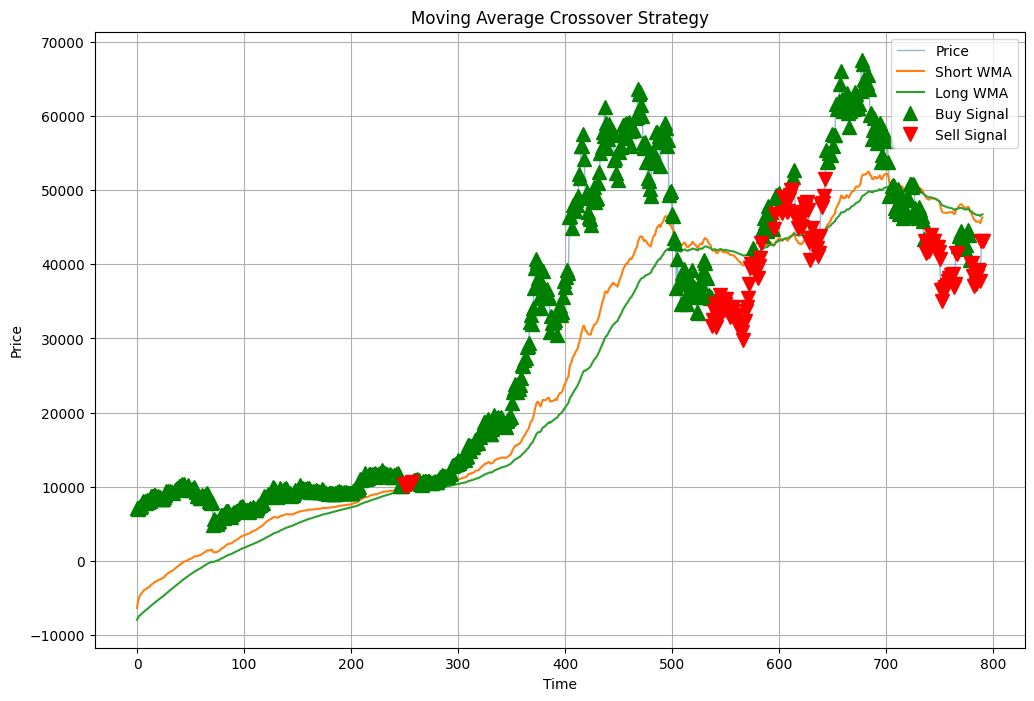

Test set fitness: 1416.14


In [ ]:
# PSO Invoke

data = import_data(DATA_PATH)
training_data, testing_data = training_testing_split(data, datetime(2020, 1, 1).timestamp())

prices = training_data[1]

#EUSHA
# Defining the bounds for the parameters (14 total)
bounds = [
    [0, 1],    # short_wma_weight_1
    [1, 200], # short_wma_length_1
    [0, 1],    # short_wma_weight_2
    [1, 200], # short_wma_length_2
    [0, 1],    # short_wma_weight_3
    [1, 200], # short_wma_length_3
    [0.01, 1],    # short_wma_alpha for EMA
    [0, 1],    # long_wma_weight_1
    [1, 200], # long_wma_length_1
    [0, 1],    # long_wma_weight_2
    [1, 200], # long_wma_length_2
    [0, 1],    # long_wma_weight_3
    [1, 200], # long_wma_length_3
    [0.01, 1]     # long_wma_alpha for EMA (second one)
]

# Wrapping the evaluate function to accept only weights
def fitness_function(weights):
    return evaluate(weights, prices)

# Initialize and run PSO
pso = ParticleSwarmOptimizer(
    fitness_function=fitness_function,
    bounds=bounds,
    num_particles=100,
    max_iter=100
)

best_params, best_score = pso.optimize()

print("Best Score: ", best_score)
print("Best Parameters: ")
print_parameters(best_params)

# Evaluate best parameters on test set
test_fitness = evaluate(best_params, testing_data[1], plot=True)
print(f"Test set fitness: {test_fitness:.2f}")

In [ ]:
# HCA Implementation

class HCA:
    def __init__(self, objective_func, bounds, step_size=0.1, n_iterations=1000):
        """
        Hill Climbing Algorithm implementation

        Parameters:
        - objective_func: Objective function to optimize
        - bounds: Parameter bounds [(min, max), ...]
        - step_size: Size of step for parameter updates
        - n_iterations: Number of iterations
        """
        self.objective_func = objective_func
        self.bounds = bounds
        self.step_size = step_size
        self.n_iterations = n_iterations
        self.dim = len(bounds)

        # Initialize current position
        self.current_position = np.random.uniform(
            [b[0] for b in bounds],
            [b[1] for b in bounds]
        )

        # Initialize current fitness
        self.current_fitness = self.objective_func(self.current_position)

    def generate_neighbor(self, position):
        """Generate a neighboring solution"""
        neighbor = position.copy()

        # Randomly select a dimension to modify
        dim = np.random.randint(self.dim)

        # Generate a random step
        step = np.random.uniform(-self.step_size, self.step_size)

        # Update the selected dimension
        neighbor[dim] += step

        # Ensure the new value is within bounds
        neighbor[dim] = np.clip(neighbor[dim], self.bounds[dim][0], self.bounds[dim][1])

        return neighbor

    def optimize(self):
        """Execute optimization"""
        best_position = self.current_position.copy()
        best_fitness = self.current_fitness

        for iteration in range(self.n_iterations):
            # Generate a neighbor
            neighbor = self.generate_neighbor(self.current_position)

            # Evaluate the neighbor
            neighbor_fitness = self.objective_func(neighbor)

            # If the neighbor is better, move to it
            if neighbor_fitness > self.current_fitness:
                self.current_position = neighbor
                self.current_fitness = neighbor_fitness

                # Update best solution if necessary
                if neighbor_fitness > best_fitness:
                    best_position = neighbor.copy()
                    best_fitness = neighbor_fitness

            print(
                f"Iteration {iteration + 1}/{self.n_iterations}, Current fitness: {self.current_fitness:.2f}, Best fitness: {best_fitness:.2f}")

        return best_position, best_fitness


Iteration 1/1000, Current fitness: 276.49, Best fitness: 276.49
Iteration 2/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 3/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 4/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 5/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 6/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 7/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 8/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 9/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 10/1000, Current fitness: 285.84, Best fitness: 285.84
Iteration 11/1000, Current fitness: 306.22, Best fitness: 306.22
Iteration 12/1000, Current fitness: 306.22, Best fitness: 306.22
Iteration 13/1000, Current fitness: 306.22, Best fitness: 306.22
Iteration 14/1000, Current fitness: 306.22, Best fitness: 306.22
Iteration 15/1000, Current fitness: 1000.00, Best fitness: 1000.00
Iteration 16/1000, Current fitne

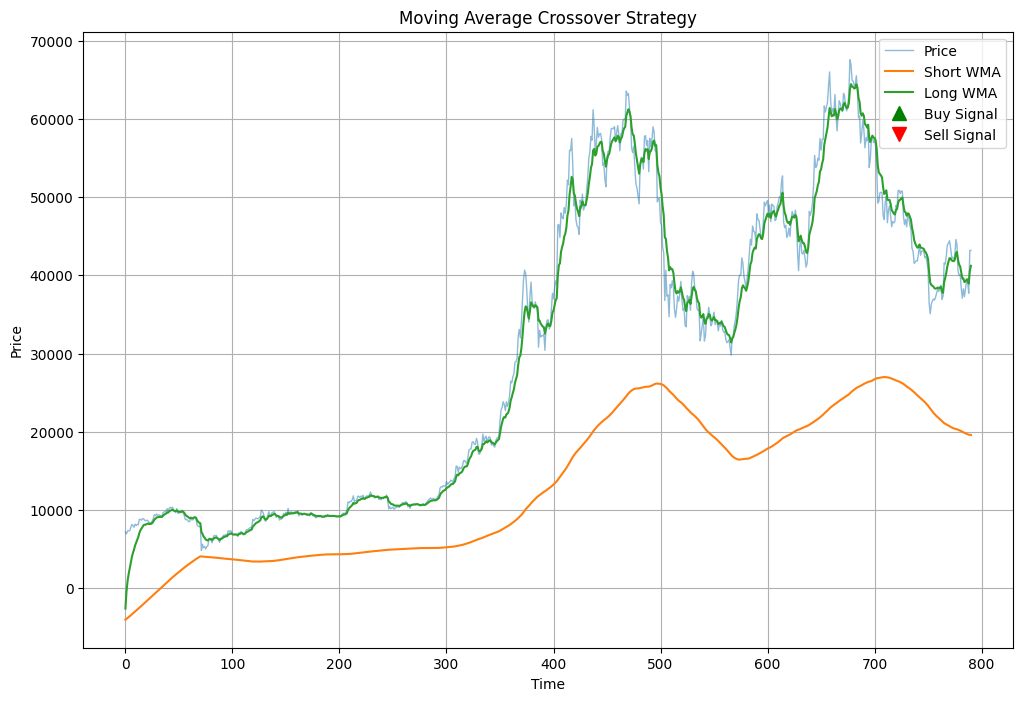

Test set fitness: 1000.00


In [ ]:
#HCA Invoke

# Import data
data = import_data(DATA_PATH)
training_data, testing_data = training_testing_split(data, datetime(2020, 1, 1).timestamp())

# Define parameter bounds
bounds = [
    (0, 1), (1, 200),           # SMA parameters
    (0, 1), (1, 200),           # LMA parameters
    (0, 1), (1, 200), (0, 1),   # EMA parameters
    (0, 1), (1, 200),           # SMA parameters
    (0, 1), (1, 200),           # LMA parameters
    (0, 1), (1, 200), (0, 1)    # EMA parameters
]


# Create objective function
def objective_function(params):
    return evaluate(params, training_data[1])


# Create HCA optimizer
hca = HCA(
    objective_func=objective_function,
    bounds=bounds,
    step_size=0.1,
    n_iterations=1000
)

# Execute optimization
best_params, best_fitness = hca.optimize()

print("\nOptimization Results:")
print(f"Best parameters: {best_params}")
print(f"Best fitness: {best_fitness:.2f}")

# Evaluate best parameters on test set
test_fitness = evaluate(best_params, testing_data[1], plot=True)
print(f"Test set fitness: {test_fitness:.2f}")

In [ ]:
# ABC Implementation
class ABC:
    def __init__(self, objective_func, bounds, n_bees=50, n_iterations=100, limit=50):
        """
        Artificial Bee Colony Algorithm implementation

        Parameters:
        - objective_func: Objective function to optimize
        - bounds: Parameter bounds [(min, max), ...]
        - n_bees: Number of bees
        - n_iterations: Number of iterations
        - limit: Maximum number of trials
        """
        self.objective_func = objective_func
        self.bounds = bounds
        self.n_bees = n_bees
        self.n_iterations = n_iterations
        self.limit = limit
        self.dim = len(bounds)

        # Initialize bee positions
        self.positions = np.random.uniform(
            [b[0] for b in bounds],
            [b[1] for b in bounds],
            (n_bees, self.dim)
        )

        # Initialize fitness
        self.fitness = np.zeros(n_bees)
        self.trials = np.zeros(n_bees)
        self.best_solution = None
        self.best_fitness = float('-inf')

    def evaluate_fitness(self, position):
        """Evaluate fitness of a position"""
        return self.objective_func(position)

    def employed_bee_phase(self):
        """Employed bee phase"""
        for i in range(self.n_bees):
            # Randomly select a dimension
            j = np.random.randint(self.dim)
            # Randomly select a different bee
            k = np.random.randint(self.n_bees)
            while k == i:
                k = np.random.randint(self.n_bees)

            # Generate new solution
            new_position = self.positions[i].copy()
            phi = np.random.uniform(-1, 1)
            new_position[j] = self.positions[i][j] + phi * (self.positions[i][j] - self.positions[k][j])

            # Ensure new solution is within bounds
            new_position[j] = np.clip(new_position[j], self.bounds[j][0], self.bounds[j][1])

            # Evaluate new solution
            new_fitness = self.evaluate_fitness(new_position)

            # Update if new solution is better
            if new_fitness > self.fitness[i]:
                self.positions[i] = new_position
                self.fitness[i] = new_fitness
                self.trials[i] = 0
            else:
                self.trials[i] += 1

    def onlooker_bee_phase(self):
        """Onlooker bee phase"""
        # Calculate selection probabilities
        fitness_sum = np.sum(self.fitness)
        if fitness_sum == 0:
            probabilities = np.ones(self.n_bees) / self.n_bees
        else:
            probabilities = self.fitness / fitness_sum

        for _ in range(self.n_bees):
            # Roulette wheel selection
            i = np.random.choice(self.n_bees, p=probabilities)

            # Randomly select a dimension
            j = np.random.randint(self.dim)
            # Randomly select a different bee
            k = np.random.randint(self.n_bees)
            while k == i:
                k = np.random.randint(self.n_bees)

            # Generate new solution
            new_position = self.positions[i].copy()
            phi = np.random.uniform(-1, 1)
            new_position[j] = self.positions[i][j] + phi * (self.positions[i][j] - self.positions[k][j])

            # Ensure new solution is within bounds
            new_position[j] = np.clip(new_position[j], self.bounds[j][0], self.bounds[j][1])

            # Evaluate new solution
            new_fitness = self.evaluate_fitness(new_position)

            # Update if new solution is better
            if new_fitness > self.fitness[i]:
                self.positions[i] = new_position
                self.fitness[i] = new_fitness
                self.trials[i] = 0
            else:
                self.trials[i] += 1

    def scout_bee_phase(self):
        """Scout bee phase"""
        for i in range(self.n_bees):
            if self.trials[i] >= self.limit:
                # Reinitialize the position of this bee
                self.positions[i] = np.random.uniform(
                    [b[0] for b in self.bounds],
                    [b[1] for b in self.bounds],
                    self.dim
                )
                self.fitness[i] = self.evaluate_fitness(self.positions[i])
                self.trials[i] = 0

    def optimize(self):
        """Execute optimization"""
        # Initialize fitness
        for i in range(self.n_bees):
            self.fitness[i] = self.evaluate_fitness(self.positions[i])

        # Record best solution
        best_idx = np.argmax(self.fitness)
        self.best_solution = self.positions[best_idx].copy()
        self.best_fitness = self.fitness[best_idx]

        # Iterative optimization
        for iteration in range(self.n_iterations):
            self.employed_bee_phase()
            self.onlooker_bee_phase()
            self.scout_bee_phase()

            # Update best solution
            current_best_idx = np.argmax(self.fitness)
            if self.fitness[current_best_idx] > self.best_fitness:
                self.best_solution = self.positions[current_best_idx].copy()
                self.best_fitness = self.fitness[current_best_idx]

            print(f"Iteration {iteration + 1}/{self.n_iterations}, Best fitness: {self.best_fitness:.2f}")

        return self.best_solution, self.best_fitness


Iteration 1/100, Best fitness: 24366.73
Iteration 2/100, Best fitness: 29407.83
Iteration 3/100, Best fitness: 33668.88
Iteration 4/100, Best fitness: 33668.88
Iteration 5/100, Best fitness: 35975.13
Iteration 6/100, Best fitness: 35975.13
Iteration 7/100, Best fitness: 35975.13
Iteration 8/100, Best fitness: 35975.13
Iteration 9/100, Best fitness: 35975.13
Iteration 10/100, Best fitness: 35975.13
Iteration 11/100, Best fitness: 35975.13
Iteration 12/100, Best fitness: 35975.13
Iteration 13/100, Best fitness: 37653.64
Iteration 14/100, Best fitness: 38028.51
Iteration 15/100, Best fitness: 38028.51
Iteration 16/100, Best fitness: 38497.41
Iteration 17/100, Best fitness: 38497.41
Iteration 18/100, Best fitness: 38497.41
Iteration 19/100, Best fitness: 38497.41
Iteration 20/100, Best fitness: 38497.41
Iteration 21/100, Best fitness: 38497.41
Iteration 22/100, Best fitness: 38497.41
Iteration 23/100, Best fitness: 45080.69
Iteration 24/100, Best fitness: 45080.69
Iteration 25/100, Best fi

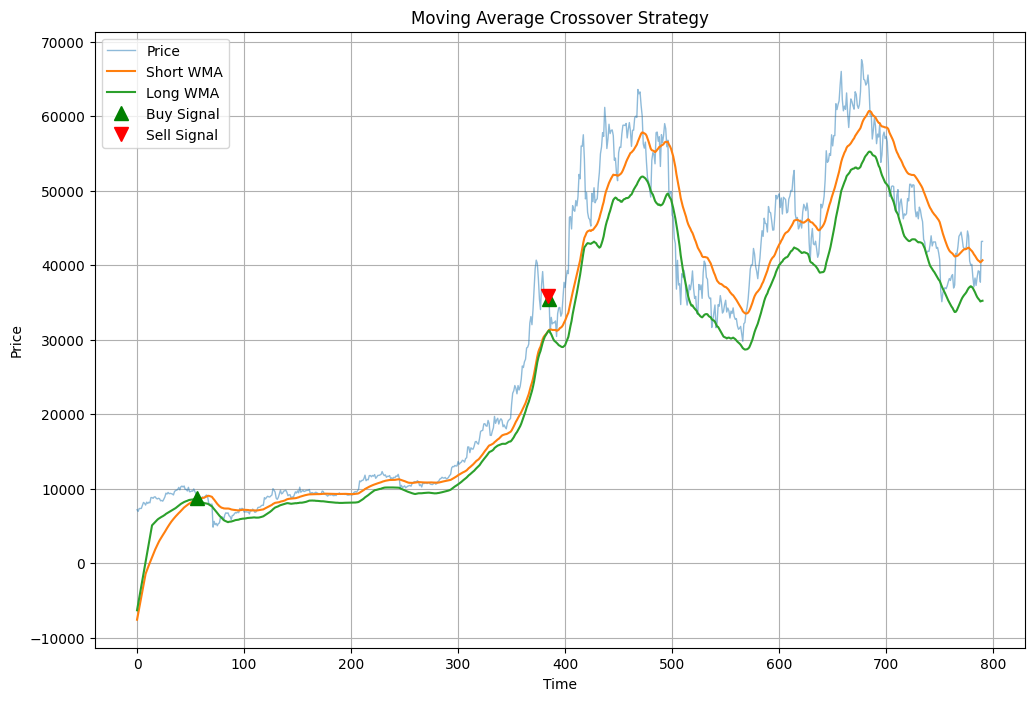

Test set fitness: 4406.35


In [ ]:
# ABC Invoke

# Main program
# Import data
data = import_data(DATA_PATH)
training_data, testing_data = training_testing_split(data, datetime(2020, 1, 1).timestamp())

# Define parameter bounds
bounds = [
    (0, 1), (1, 200),           # SMA parameters
    (0, 1), (1, 200),           # LMA parameters
    (0, 1), (1, 200), (0, 1),   # EMA parameters
    (0, 1), (1, 200),           # SMA parameters
    (0, 1), (1, 200),           # LMA parameters
    (0, 1), (1, 200), (0, 1)    # EMA parameters
]


# Create objective function
def objective_function(params):
    return evaluate(params, training_data[1])


# Create ABC optimizer
abc = ABC(
    objective_func=objective_function,
    bounds=bounds,
    n_bees=50,
    n_iterations=100,
    limit=50
)

# Execute optimization
best_params, best_fitness = abc.optimize()

print("\nOptimization Results:")
print(f"Best parameters: {best_params}")
print(f"Best fitness: {best_fitness:.2f}")

# Evaluate best parameters on test set
test_fitness = evaluate(best_params, testing_data[1], plot=True)
print(f"Test set fitness: {test_fitness:.2f}")

In [ ]:
# Comparison function of all algorithms
# Comparison Table:
import pandas as pd
from datetime import datetime

def run_all_optimizers(data_path, n_runs=3): # We acn change how many times we want to run each of the algorithms
    results = []

    for run in range(1, n_runs + 1):
        print(f"\n=== Run {run} ===")
        data = import_data(data_path)
        training_data, testing_data = training_testing_split(data, datetime(2020, 1, 1).timestamp())
        prices = training_data[1]

        # PSO
        pso_bounds = [
            [0, 1], [1, 500], [0, 1], [1, 500],
            [0, 1], [1, 500], [0.01, 1],
            [0, 1], [1, 500], [0, 1], [1, 500],
            [0, 1], [1, 500], [0.01, 1]
        ]

        pso = ParticleSwarmOptimizer(
            fitness_function=lambda w: evaluate(w, prices),
            bounds=pso_bounds,
            num_particles=100,
            max_iter=100
        )
        pso_best_params, pso_best_train = pso.optimize()
        pso_test_score = evaluate(pso_best_params, testing_data[1], plot=False)

        results.append({
            "Run": run,
            "Algorithm": "PSO",
            "Train Score": pso_best_train,
            "Test Score": pso_test_score
        })

        # HCA
        hca_bounds = [
            (0, 1), (1, 100), (0, 1),
            (1, 100), (0, 1), (1, 100),
            (0, 1), (0, 1), (1, 100),
            (0, 1), (1, 100), (0, 1),
            (1, 100), (0, 1), (1, 100),
            (0, 1)
        ]

        hca = HCA(
            objective_func=lambda p: evaluate(p, training_data[1]),
            bounds=hca_bounds,
            step_size=0.1,
            n_iterations=1000
        )
        hca_best_params, hca_best_train = hca.optimize()
        hca_test_score = evaluate(hca_best_params, testing_data[1], plot=False)

        results.append({
            "Run": run,
            "Algorithm": "HCA",
            "Train Score": hca_best_train,
            "Test Score": hca_test_score
        })

        # ABC
        abc = ABC(
            objective_func=lambda p: evaluate(p, training_data[1]),
            bounds=hca_bounds,  # same as HCA
            n_bees=50,
            n_iterations=100,
            limit=50
        )
        abc_best_params, abc_best_train = abc.optimize()
        abc_test_score = evaluate(abc_best_params, testing_data[1], plot=False)

        results.append({
            "Run": run,
            "Algorithm": "ABC",
            "Train Score": abc_best_train,
            "Test Score": abc_test_score
        })

    return pd.DataFrame(results)

results_df = run_all_optimizers(DATA_PATH, n_runs=3)
print(results_df)


=== Run 1 ===
Iteration 1/1000, Current fitness: 1906.09, Best fitness: 1906.09
Iteration 2/1000, Current fitness: 1906.09, Best fitness: 1906.09
Iteration 3/1000, Current fitness: 1906.09, Best fitness: 1906.09
Iteration 4/1000, Current fitness: 1906.09, Best fitness: 1906.09
Iteration 5/1000, Current fitness: 1906.09, Best fitness: 1906.09
Iteration 6/1000, Current fitness: 1906.09, Best fitness: 1906.09
Iteration 7/1000, Current fitness: 2155.46, Best fitness: 2155.46
Iteration 8/1000, Current fitness: 2155.46, Best fitness: 2155.46
Iteration 9/1000, Current fitness: 2155.46, Best fitness: 2155.46
Iteration 10/1000, Current fitness: 2155.46, Best fitness: 2155.46
Iteration 11/1000, Current fitness: 2581.19, Best fitness: 2581.19
Iteration 12/1000, Current fitness: 2581.19, Best fitness: 2581.19
Iteration 13/1000, Current fitness: 2581.19, Best fitness: 2581.19
Iteration 14/1000, Current fitness: 2581.19, Best fitness: 2581.19
Iteration 15/1000, Current fitness: 2581.19, Best fitnes